# Graphene metamaterial absorber

Graphene, a single atomic sheet of carbon atoms arranged in a hexagonal lattice, has shown great promise for functional optical and optoelectronic devices. Compared to devices made of conventional materials, graphene-based devices have a unique tunability advantage since graphene's conductivity can be drastically modulated by electrostatic gating. 

Due to its atomic thickness, it is usually very difficult to model graphene in an FDTD simulation without using a large number of grid points. Fortunately, Tidy3D natively supports a surface conductivity model such that thin material layers can be accurately simulated even with grids much larger than the actual layer thickness. More specifically, you can model graphene directly using Tidy3D's [Material Library](../material_library.html?highlight=material%20ibrary). The graphene's conductivity is described by the well established Kubo formula, which includes the  contributions from the intraband and interband electronic transitions. To define graphene, a few parameters, namely the scattering rate, chemical potential, and temperature, are required as user inputs.

This notebook demonstrates how to model a graphene fishnet metamaterial absorber in the THz frequency range. By forming a Fabry-Perot resonator between the graphene layer and a metal mirror, high absorption is achieved across a bandwidth of ~ 2 THz. The design is adapted from the seminal work [Andrei Andryieuski and Andrei V. Lavrinenko, "Graphene metamaterials based tunable terahertz absorber: effective surface conductivity approach," Opt. Express 21, 9144-9155 (2013)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-21-7-9144&id=252404&ibsearch=false).

<img src="img/graphene_metamaterial_schematic.png" width="400">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web


The overall design of the absorber involves two layers of graphene sheets embedded in TOPAS polymer. The bottom of the device is a metallic mirror, which forms a Fabry-Perot resonator with graphene. This resonator greatly amplifies the absorption in graphene and achieves perfect absorption when the resonance condition is met. Two designs are explored in this notebook. The first one is a simple uniform graphene layer. When the chemical potential of graphene is tuned to 0.5 eV, perfect absorption is achieved but only within a narrow frequency band. Then, we test a fishnet structure, which shows a much wider absorption band. 

## Uniform Graphene Sheet Absorber

We start with a simpler case where the absorber is made of two uniform graphene layers embedded in TOPAS polymer above a ground plate. 

First, define the basic simulation parameters.

In [2]:
THz = 1e12  # 1 THz = 1e12 Hz

freq0 = 2.5 * THz  # central frequency
freqs = np.linspace(0.1, 5, 300) * THz  # frequency range of interest

lda0 = td.C_0 / freq0  # central wavelength


The TOPAS polymer has a refractive index of 1.53 in the THz range with little absorption. 

In [3]:
n_topas = 1.53  # refractive index of the polymer
topas = td.Medium(permittivity=n_topas**2)


To define graphene conductivity, we need to specify a few parameters. Here, we consider a relaxation time of $\tau$=0.1 ps, which translates to a scattering rate $\Gamma=\frac{1}{2\tau}=\frac{6.58e-16}{2 \times 1e-13}=$0.0033 eV, where 6.58e-16 is $\hbar$ in the unit of eV*s. The temperature is at room temperature. Since there are two layers of graphene, the scaling parameter is set to 2. Note that this only works for graphene layers separated by a small distance. For real bilayer graphene or few-layer graphene in general, the conductivity is more complex as interlayer coupling and stacking order play an important role.

In [4]:
gamma = 0.0033  # scattering rate
temp = 300  # temperature
scaling = 2  # number of layers.


Furthermore, we consider a unit cell size of 15 $\mu m$. In the uniform graphene sheet absorber, the distance between the graphene and the mirror is 35.9 $\mu m$.

In [5]:
a = 15  # unit cell size
h = 35.9  # distance between graphene and the ground plate
offset = lda0 / 2  # distance between the flux monitor and the graphene


The periodic boundary condition is applied in both the $x$ and $y$ directions. In the $z$ direction, PML is applied in the plus direction and PEC is applied in the minus direction. The PEC mimics the metal mirror. For the grids, we use automatic nonuniform grids in all directions. The same [BoundarySpec](../_autosummary/tidy3d.BoundarySpec.html?highlight=BOUNDARYSPEC) and [GridSpec](../_autosummary/tidy3d.GridSpec.html?highlight=gridspec) will be used through the notebook.

In [6]:
# define a BoundarySpec
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary(minus=td.PECBoundary(), plus=td.PML()),
)

# define a GridSpec
grid_spec = td.GridSpec.auto(min_steps_per_wvl=200, wavelength=lda0)

# simulation run time
run_time = 1e-11


Next we define a function that returns a simulation at a given graphene chemical potential. This function will later be called repeatedly to construct a simulation batch to investigate how the chemical potential affects the absorption spectrum.

In [7]:
def make_sim_uniform(mu_c):

    # define graphene
    graphene = td.material_library["graphene"](
        gamma=gamma, mu_c=mu_c, temp=temp, scaling=scaling
    ).medium

    # define graphene structure
    graphene_layer = td.Structure(
        geometry=td.Box(center=(0, 0, h), size=(td.inf, td.inf, 0)), medium=graphene
    )

    # define a plane wave source
    plane_wave = td.PlaneWave(
        center=(0, 0, h + 0.1 * offset),
        size=(td.inf, td.inf, 0),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 2),
        direction="-",
    )

    # define a flux monitor to measure reflection
    flux_monitor = td.FluxMonitor(
        center=(0, 0, h + offset),
        size=(td.inf, td.inf, 0),
        freqs=freqs,
        name="R",
    )

    # simulation domain size in z
    Lz = h + 1.1 * offset

    # define simulation
    sim = td.Simulation(
        center=(0, 0, Lz / 2),
        size=(a, a, Lz),
        grid_spec=grid_spec,
        structures=[graphene_layer],
        sources=[plane_wave],
        monitors=[flux_monitor],
        run_time=run_time,
        medium=topas,
        boundary_spec=boundary_spec,
        shutoff=1e-7,
        symmetry=(-1, 1, 0),  # symmetry is used to reduce the computational load
    )

    return sim


Specifically, we study $\mu_c=$0, 0.1, 0.2, and 0.5 eV. 

In [8]:
mu_cs = [0, 0.1, 0.2, 0.5]  # values of mu_c to be simulated

# define a simulation batch
sims = {f"mu_c={mu_c:.2f}": make_sim_uniform(mu_c) for mu_c in mu_cs}


Submit the simulation batch to the server.

In [9]:
batch = web.Batch(simulations=sims, folder_name="default")
batch_results = batch.run(path_dir="data")


[14:45:54] Created task 'mu_c=0.00' with task_id 'fdve-807eac20-78b4-4842-97cf-e74057e763c0v1'.       ]8;id=216643;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=6937;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=54287;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=960229;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=976637;https://tidy3d.simulation.cloud/workbench?taskId=fdve-807eac20-78b4-4842-97cf-e74057e763c0v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=794293;https://tidy3d.simulation.cloud/workbench?taskId=fdve-807eac20-78b4-4842-97cf-e74057e763c0v1\taskId]8;;\]8;id=976637;https://tidy3d.simulation.cloud/workbench?taskId=fdve-807eac20-78b4-4842-97cf-e74057e763c0v1\=]8;;\]8;id=685132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-807eac20-78b4-4842-97cf-e74057e763c0v1\fdve]8;;\]8;id=976637;https://tidy3d.simulation.cloud/workbench?taskId=fdve-807eac20-78b4-4842-97cf-e74057e763c0v1\-807eac20-78b4-4842-97cf-e74057e763c]8;;\              
           ]8;id=976637;https://tidy3d.simulation.cloud/workbench?taskId=fdve-807eac20-78b4-4842-97cf-e74057e763c0v1\0v1']8;;\.                                                                                                   

Output()

[14:45:55] Created task 'mu_c=0.10' with task_id 'fdve-d3a612a5-7467-4b1a-822b-aec1b226243cv1'.       ]8;id=851915;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=457207;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=298994;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=981433;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=792771;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a612a5-7467-4b1a-822b-aec1b226243cv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=855989;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a612a5-7467-4b1a-822b-aec1b226243cv1\taskId]8;;\]8;id=792771;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a612a5-7467-4b1a-822b-aec1b226243cv1\=]8;;\]8;id=346835;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a612a5-7467-4b1a-822b-aec1b226243cv1\fdve]8;;\]8;id=792771;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a612a5-7467-4b1a-822b-aec1b226243cv1\-d3a612a5-7467-4b1a-822b-aec1b226243]8;;\              
           ]8;id=792771;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3a612a5-7467-4b1a-822b-aec1b226243cv1\cv1']8;;\.                                                                                                   

Output()

[14:45:55] Created task 'mu_c=0.20' with task_id 'fdve-84950e99-1531-42ec-857d-4e8faeb6dec7v1'.       ]8;id=114124;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=768426;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=877215;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=650693;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=202601;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84950e99-1531-42ec-857d-4e8faeb6dec7v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=313640;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84950e99-1531-42ec-857d-4e8faeb6dec7v1\taskId]8;;\]8;id=202601;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84950e99-1531-42ec-857d-4e8faeb6dec7v1\=]8;;\]8;id=589830;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84950e99-1531-42ec-857d-4e8faeb6dec7v1\fdve]8;;\]8;id=202601;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84950e99-1531-42ec-857d-4e8faeb6dec7v1\-84950e99-1531-42ec-857d-4e8faeb6dec]8;;\              
           ]8;id=202601;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84950e99-1531-42ec-857d-4e8faeb6dec7v1\7v1']8;;\.                                                                                                   

Output()

[14:45:56] Created task 'mu_c=0.50' with task_id 'fdve-2390f282-8e3d-49a4-b164-8b37cd1ef33ev1'.       ]8;id=151873;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=301918;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=72423;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=387178;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=194604;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2390f282-8e3d-49a4-b164-8b37cd1ef33ev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=299970;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2390f282-8e3d-49a4-b164-8b37cd1ef33ev1\taskId]8;;\]8;id=194604;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2390f282-8e3d-49a4-b164-8b37cd1ef33ev1\=]8;;\]8;id=141637;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2390f282-8e3d-49a4-b164-8b37cd1ef33ev1\fdve]8;;\]8;id=194604;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2390f282-8e3d-49a4-b164-8b37cd1ef33ev1\-2390f282-8e3d-49a4-b164-8b37cd1ef33]8;;\              
           ]8;id=194604;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2390f282-8e3d-49a4-b164-8b37cd1ef33ev1\ev1']8;;\.                                                                                                   

Output()

[14:45:58] Started working on Batch.                                                               ]8;id=247603;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=202669;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#457\457]8;;\

Output()

[14:46:20] Batch complete.                                                                         ]8;id=221670;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=342215;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#497\497]8;;\

After the batch of jobs is complete, we want to plot the absorption spectra. Since the bottom ground plane is a perfect mirror, absorption is simply $A=1-R$, where $R$ is the reflection. A function `plot_absorption` is defined to do this plotting. 

In [10]:
def plot_absorption(batch_results):
    for i, mu_c in enumerate(mu_cs):
        sim_data = batch_results[f"mu_c={mu_c:.2f}"]
        A = 1 - sim_data["R"].flux
        plt.plot(freqs / THz, A, label=f"{mu_c:.2f} eV")
        plt.xlim(0, 5)
        plt.ylim(0, 1)
        plt.xlabel("Frequency (THz)")
        plt.ylabel("Absorption")
        plt.legend()


At 0.5 eV chemical potential, perfect absorption is observed around 2.3 THz. However, the bandwidth is rather small.

Output()

[14:46:21] loading SimulationData from data/fdve-807eac20-78b4-4842-97cf-e74057e763c0v1.hdf5          ]8;id=122556;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=122290;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

Output()

[14:46:21] loading SimulationData from data/fdve-d3a612a5-7467-4b1a-822b-aec1b226243cv1.hdf5          ]8;id=967446;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=560167;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

Output()

[14:46:22] loading SimulationData from data/fdve-84950e99-1531-42ec-857d-4e8faeb6dec7v1.hdf5          ]8;id=424627;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=797467;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

Output()

[14:46:22] loading SimulationData from data/fdve-2390f282-8e3d-49a4-b164-8b37cd1ef33ev1.hdf5          ]8;id=762951;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=487602;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

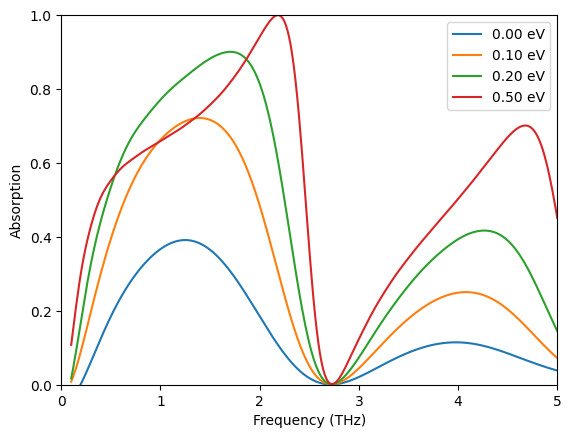

In [11]:
plot_absorption(batch_results)


## Graphene Fishnet Absorber

To enhance the absorption bandwidth, a fishnet design is explored, as discussed in the [reference](https://opg.optica.org/oe/fulltext.cfm?uri=oe-21-7-9144&id=252404&ibsearch=false).

Similarly, we define a function here that returns a simulation at a given graphene chemical potential. 

In [12]:
# fishnet parameters
b = 2
w = 12

h = 17.6  # distance between the graphene and the ground plate
inf_eff = 1e3  # effective infinity


def make_sim_fishnet(mu_c):
    # define graphene
    graphene = td.material_library["graphene"](
        gamma=gamma, mu_c=mu_c, temp=temp, scaling=scaling
    ).medium

    # define the fishnet structure
    graphene_finishnet_center = td.Structure(
        geometry=td.Box.from_bounds(rmin=(0, 0, h), rmax=(w / 2, w / 2, h)),
        medium=graphene,
    )
    graphene_finishnet_right = td.Structure(
        geometry=td.Box.from_bounds(rmin=(w / 2, 0, h), rmax=(inf_eff, b / 2, h)),
        medium=graphene,
    )
    graphene_finishnet_top = td.Structure(
        geometry=td.Box.from_bounds(rmin=(0, w / 2, h), rmax=(b / 2, inf_eff, h)),
        medium=graphene,
    )

    # define a plane wave source
    plane_wave = td.PlaneWave(
        center=(0, 0, h + 0.1 * offset),
        size=(td.inf, td.inf, 0),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 2),
        direction="-",
    )

    # define a flux monitor to measure reflection
    flux_monitor = td.FluxMonitor(
        center=(0, 0, h + offset),
        size=(td.inf, td.inf, 0),
        freqs=freqs,
        name="R",
    )

    # simulation domain size in z
    Lz = h + 1.1 * offset

    # define simulation
    sim = td.Simulation(
        center=(0, 0, Lz / 2),
        size=(a, a, Lz),
        grid_spec=grid_spec,
        structures=[
            graphene_finishnet_center,
            graphene_finishnet_right,
            graphene_finishnet_top,
        ],
        sources=[plane_wave],
        monitors=[flux_monitor],
        run_time=run_time,
        medium=topas,
        boundary_spec=boundary_spec,
        shutoff=1e-7,
        symmetry=(-1, 1, 0),
    )

    return sim


To make sure the structures are defined correctly, use the `plot` method to visualize the fishnet. Due to symmetry, only a quarter of it needs to be defined.

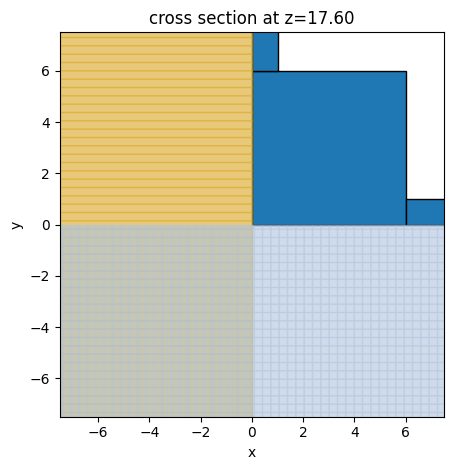

In [13]:
sim = make_sim_fishnet(0.5)
ax = sim.plot(z=h)


A batch of simulations at different chemical potentials is defined and submitted to the server. 

In [14]:
mu_cs = [0, 0.1, 0.2, 0.5]  # values of mu_c to be simulated

# define a simulation batch
sims = {f"mu_c={mu_c:.2f}": make_sim_fishnet(mu_c) for mu_c in mu_cs}

# submit the batch to the server
batch = web.Batch(simulations=sims, folder_name="default")
batch_results = batch.run(path_dir="data")


[14:46:23] Created task 'mu_c=0.00' with task_id 'fdve-d232a6f3-4ce1-4dc8-9c51-e1f3391bd83dv1'.       ]8;id=994167;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=772990;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=381800;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=903372;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=92023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d232a6f3-4ce1-4dc8-9c51-e1f3391bd83dv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=542062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d232a6f3-4ce1-4dc8-9c51-e1f3391bd83dv1\taskId]8;;\]8;id=92023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d232a6f3-4ce1-4dc8-9c51-e1f3391bd83dv1\=]8;;\]8;id=331940;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d232a6f3-4ce1-4dc8-9c51-e1f3391bd83dv1\fdve]8;;\]8;id=92023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d232a6f3-4ce1-4dc8-9c51-e1f3391bd83dv1\-d232a6f3-4ce1-4dc8-9c51-e1f3391bd83]8;;\              
           ]8;id=92023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d232a6f3-4ce1-4dc8-9c51-e1f3391bd83dv1\dv1']8;;\.                                                                                                   

Output()

[14:46:24] Created task 'mu_c=0.10' with task_id 'fdve-c68c59b4-408e-4a48-9880-8f16a4be1a58v1'.       ]8;id=565285;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=98419;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=165430;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=610071;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=678457;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c68c59b4-408e-4a48-9880-8f16a4be1a58v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=147231;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c68c59b4-408e-4a48-9880-8f16a4be1a58v1\taskId]8;;\]8;id=678457;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c68c59b4-408e-4a48-9880-8f16a4be1a58v1\=]8;;\]8;id=32606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c68c59b4-408e-4a48-9880-8f16a4be1a58v1\fdve]8;;\]8;id=678457;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c68c59b4-408e-4a48-9880-8f16a4be1a58v1\-c68c59b4-408e-4a48-9880-8f16a4be1a5]8;;\              
           ]8;id=678457;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c68c59b4-408e-4a48-9880-8f16a4be1a58v1\8v1']8;;\.                                                                                                   

Output()

[14:46:29] Created task 'mu_c=0.20' with task_id 'fdve-df1b0ad1-5e54-4ffc-9688-54e8c4b85abdv1'.       ]8;id=784409;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=616703;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=627120;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=928369;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=659686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df1b0ad1-5e54-4ffc-9688-54e8c4b85abdv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=491880;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df1b0ad1-5e54-4ffc-9688-54e8c4b85abdv1\taskId]8;;\]8;id=659686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df1b0ad1-5e54-4ffc-9688-54e8c4b85abdv1\=]8;;\]8;id=423686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df1b0ad1-5e54-4ffc-9688-54e8c4b85abdv1\fdve]8;;\]8;id=659686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df1b0ad1-5e54-4ffc-9688-54e8c4b85abdv1\-df1b0ad1-5e54-4ffc-9688-54e8c4b85ab]8;;\              
           ]8;id=659686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-df1b0ad1-5e54-4ffc-9688-54e8c4b85abdv1\dv1']8;;\.                                                                                                   

Output()

[14:46:30] Created task 'mu_c=0.50' with task_id 'fdve-2debfd51-0e77-4fde-be48-c8fdbe19fa5av1'.       ]8;id=666187;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=617623;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=870228;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=911091;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=98133;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2debfd51-0e77-4fde-be48-c8fdbe19fa5av1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=688208;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2debfd51-0e77-4fde-be48-c8fdbe19fa5av1\taskId]8;;\]8;id=98133;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2debfd51-0e77-4fde-be48-c8fdbe19fa5av1\=]8;;\]8;id=236678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2debfd51-0e77-4fde-be48-c8fdbe19fa5av1\fdve]8;;\]8;id=98133;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2debfd51-0e77-4fde-be48-c8fdbe19fa5av1\-2debfd51-0e77-4fde-be48-c8fdbe19fa5]8;;\              
           ]8;id=98133;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2debfd51-0e77-4fde-be48-c8fdbe19fa5av1\av1']8;;\.                                                                                                   

Output()

[14:46:37] Started working on Batch.                                                               ]8;id=419688;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=125192;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#457\457]8;;\

Output()

[14:46:59] Batch complete.                                                                         ]8;id=81886;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=830932;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#497\497]8;;\

At 0.5 eV, the absorber shows an absorption bandwidth (defined as absorption above 0.9) of ~2 THz, much better than the uniform graphene absorber case.

Output()

[14:47:01] loading SimulationData from data/fdve-d232a6f3-4ce1-4dc8-9c51-e1f3391bd83dv1.hdf5          ]8;id=232523;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=351104;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

Output()

[14:47:01] loading SimulationData from data/fdve-c68c59b4-408e-4a48-9880-8f16a4be1a58v1.hdf5          ]8;id=662556;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=489419;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

Output()

[14:47:02] loading SimulationData from data/fdve-df1b0ad1-5e54-4ffc-9688-54e8c4b85abdv1.hdf5          ]8;id=835673;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=818156;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

Output()

[14:47:02] loading SimulationData from data/fdve-2debfd51-0e77-4fde-be48-c8fdbe19fa5av1.hdf5          ]8;id=45050;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=449393;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

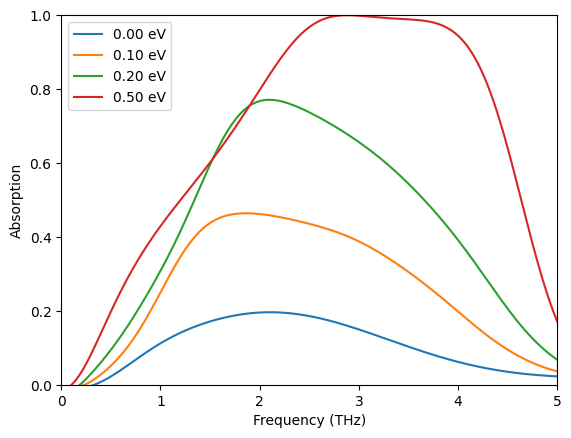

In [15]:
plot_absorption(batch_results)


## Additional Notes about Graphene 

As briefly discussed in the introduction, graphene's conductivity includes the contributions from both the intraband and interband electronic transitions. The intraband transitions lead to a Drude-like response that is dominant at lower frequencies. The interband transitions give rise to the prominent feature around $f=2\mu_c$.

The conductivity of graphene can be inspected by using the `numerical_conductivity` method. Here we show an example of graphene conductivity at $\Gamma$=0.0033 eV, $\mu_c$=0.2 eV, and $T$=300 K. Below 20 THz, the conductivity is predominantly Drude-like, which comes from the intraband transitions. The interband transition feature shows up at around 100 THz (~0.4 eV). 

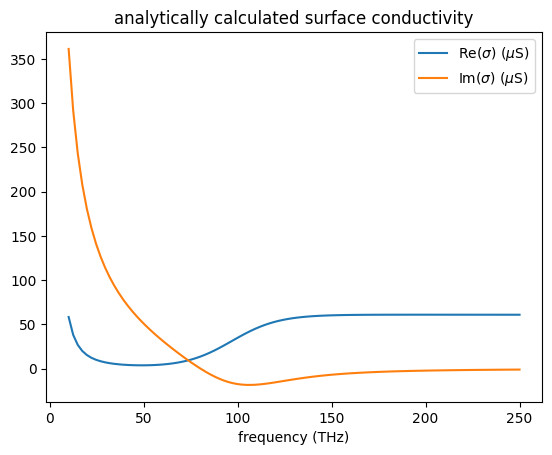

In [16]:
gamma = 0.0033  # scattering rate
mu_c = 0.2  # chemical potential
temp = 300  # temperature

freqs = np.linspace(10, 250, 100) * THz
graphene = td.material_library["graphene"](gamma=gamma, mu_c=mu_c, temp=temp)
sigma_analytical = graphene.numerical_conductivity(freqs)
plt.plot(freqs / THz, np.real(sigma_analytical * 1e6), label="Re($\sigma$) ($\mu$S)")
plt.plot(freqs / THz, np.imag(sigma_analytical * 1e6), label="Im($\sigma$) ($\mu$S)")
plt.xlabel("frequency (THz)")
plt.title("analytically calculated surface conductivity")
plt.legend()
plt.show()


Like other dispersive materials used in FDTD, graphene's conductivity needs to be fitted, which is automatically done when you define a graphene medium. The plot generated by `numerical_conductivity` above is the analytical result. To inspect the fitting, one can use the `plot_sigma` method as shown below. The fitted conductivity coincides well with the analytical result in this case.

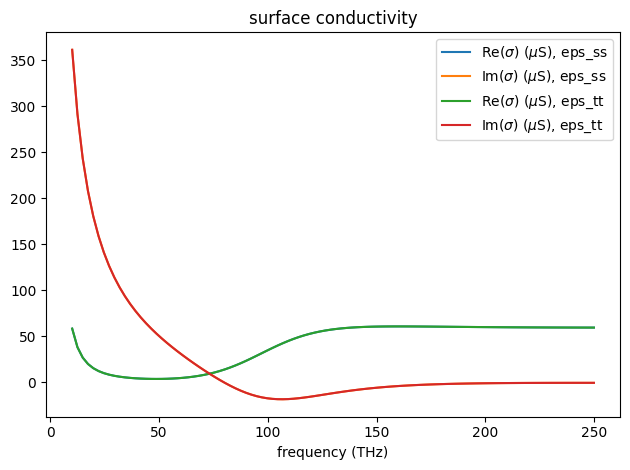

In [17]:
graphene.medium.plot_sigma(freqs)
plt.show()
